In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

# Load Dataset

In [2]:
# read `email_table.csv`
email_table = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/7.email/email_table.csv')
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
# basic information
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
# check missing values
email_table.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [5]:
# read email_opened_table.csv
email_opened = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/7.email/email_opened_table.csv')
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [6]:
# basic information
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [7]:
# read link_clicked_table.csv
link_table = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/7.email/link_clicked_table.csv')
link_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [8]:
# basic information
link_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


In [9]:
# check uniqueness of email_id in three tables
print('email_table.csv:\t', len(email_table['email_id'].unique()))
print('email_opened_table.csv:\t', len(email_opened['email_id'].unique()))
print('link_clicked_table.csv:\t', len(link_table['email_id'].unique()))

email_table.csv:	 100000
email_opened_table.csv:	 10345
link_clicked_table.csv:	 2119


# Data Processing

In [10]:
# create new columns `opened` and `clicked`
email_opened['opened'] = 1
link_table['clicked'] = 1
data = pd.merge(left=email_table, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_table, how='left', on='email_id')
data = data.fillna(value=0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


## Question 1

In [11]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', data['opened'].mean() * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', data['clicked'].mean() * 100))

Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


## Question 2

In [12]:
data.groupby('clicked')['email_id'].count() / len(data)

clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

### Visualization of email_text

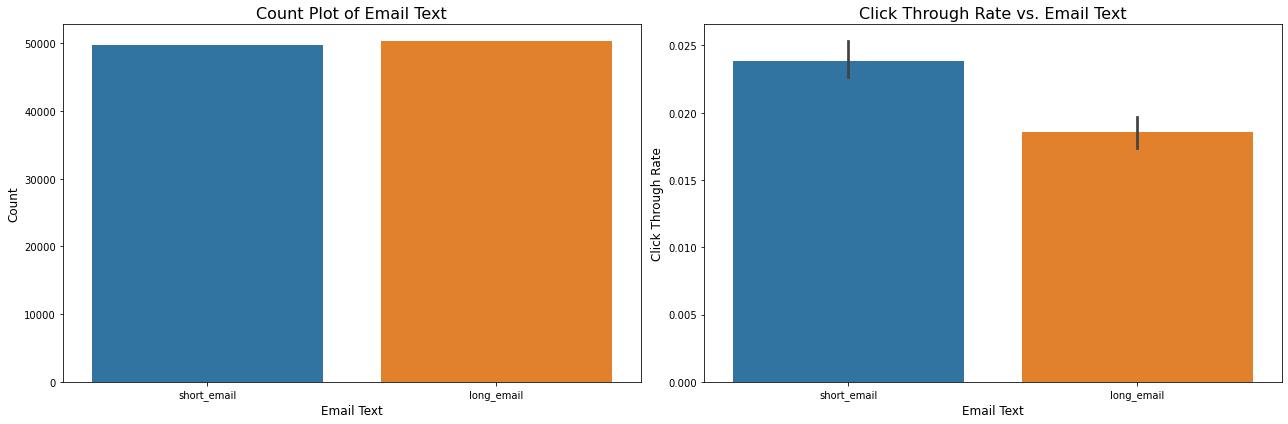

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of email_version

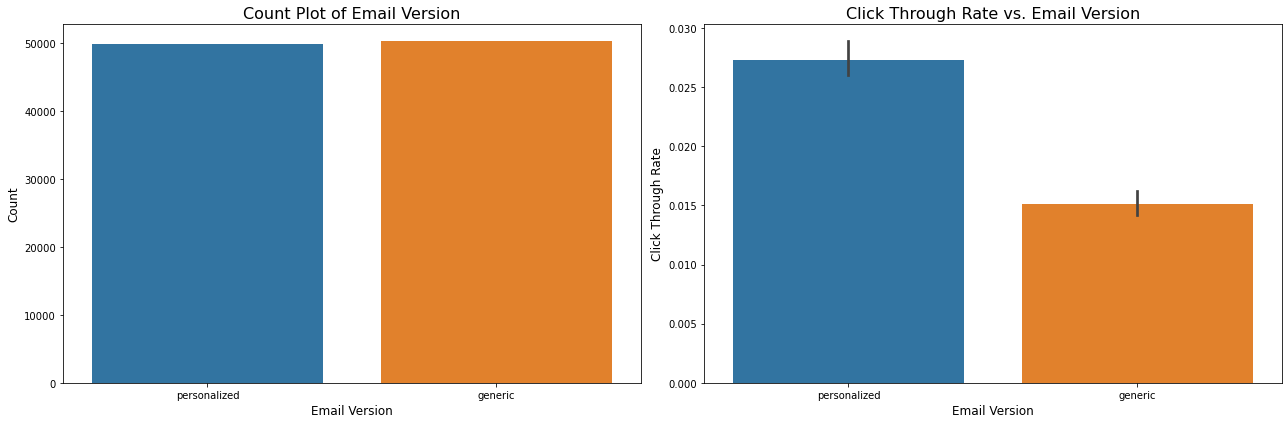

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of hour

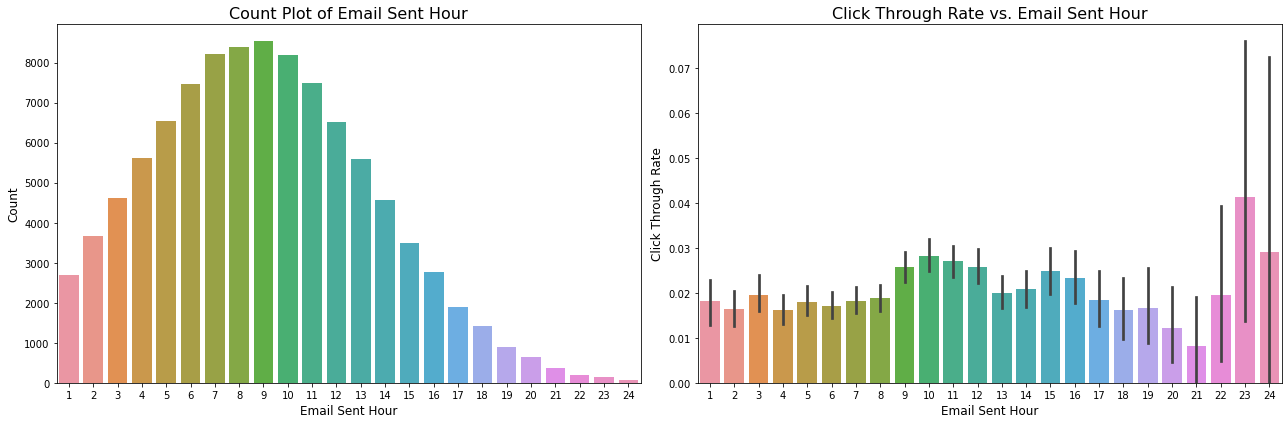

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of weekday

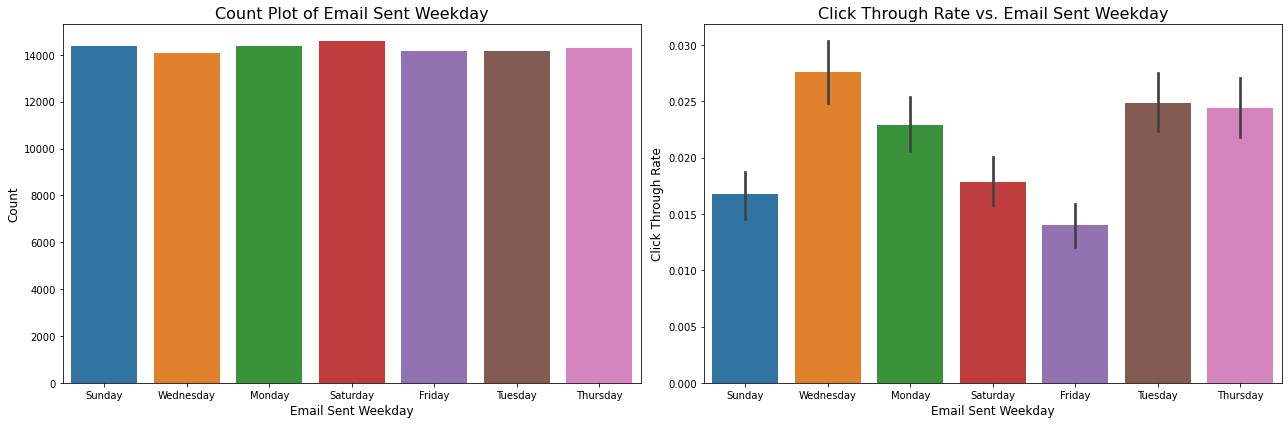

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of user_country

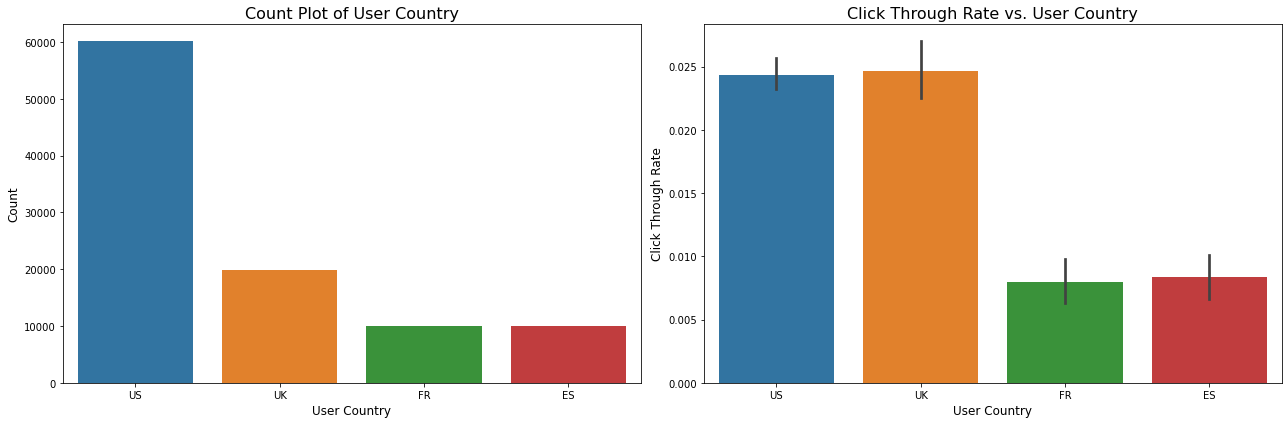

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of user_past_purchases

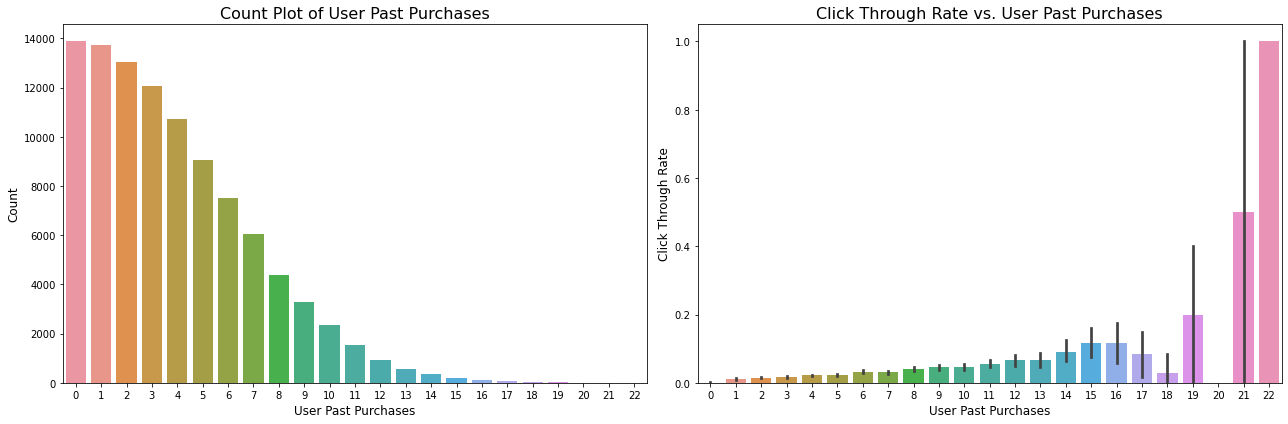

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

Clearly, different features have different influence on the user click-through-rate. Now, let's try to build some machine learning models to try to predict the click probability. In this notebook, I only implement the Random Forest model with the default parameter settings without advanced optimization, such as grid search and so on.

In [19]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,10 days 11 hours 42 mins
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,7 months and 26 days !!!
H2O_cluster_name:,H2O_from_python_kexinluo_g2s28t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.652 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [20]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.1961600027,,,9.059300000000045,,,3.878450000000022,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.7275342937,,,4.4396374417069655,,,3.1961097835771355,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0.0,0


In [21]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['clicked'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [22]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1673488071315_304


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,507628.0,10.0,10.0,10.0,240.0,469.0,398.6




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.455638087814089
RMSE: 0.6750096946074842
LogLoss: 1.620243482694707
Mean Per-Class Error: 0.22421109599256492
AUC: 0.8587712814555403
AUCPR: 0.8302194474939095
Gini: 0.7175425629110805

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.016814046818554737: 


,,0,1,Error,Rate
0,0,45335.0,28076.0,0.3824,(28076.0/73411.0)
1,1,4842.0,68552.0,0.066,(4842.0/73394.0)
2,Total,50177.0,96628.0,0.2242,(32918.0/146805.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.016814,0.806390,324.0
1,max f2,0.011999,0.899745,346.0
2,max f0point5,0.027816,0.766677,279.0
3,max accuracy,0.019429,0.778843,312.0
4,max precision,0.294444,1.000000,0.0
5,max recall,0.005431,1.000000,372.0
6,max specificity,0.294444,1.000000,0.0
7,max absolute_mcc,0.016814,0.581452,324.0
8,max min_per_class_accuracy,0.026919,0.766262,283.0
9,max mean_per_class_accuracy,0.019429,0.778856,312.0



Gains/Lift Table: Avg response rate: 49.99 %, avg score:  3.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010006,0.115358,1.952575,1.952575,0.976174,0.130448,0.976174,0.130448,0.019538,0.019538,95.257464,95.257464,0.019062
1,2,0.020006,0.099898,1.906215,1.929403,0.952997,0.106776,0.964590,0.118616,0.019062,0.038600,90.621529,92.940286,0.037183
2,3,0.030006,0.092422,1.821737,1.893522,0.910763,0.095769,0.946652,0.111002,0.018217,0.056817,82.173684,89.352233,0.053615
3,4,0.040005,0.086837,1.842175,1.880688,0.920981,0.089515,0.940235,0.105631,0.018421,0.075238,84.217518,88.068773,0.070456
4,5,0.050005,0.081910,1.825825,1.869717,0.912807,0.084376,0.934750,0.101381,0.018258,0.093495,82.582451,86.971658,0.086970
5,6,0.100003,0.066762,1.755789,1.812757,0.877793,0.073251,0.906273,0.087317,0.087786,0.181282,75.578915,81.275675,0.162538
6,7,0.150002,0.057867,1.703740,1.776419,0.851771,0.062099,0.888107,0.078911,0.085184,0.266466,70.373953,77.641932,0.232901
7,8,0.200000,0.050218,1.630979,1.740060,0.815395,0.053897,0.869929,0.072658,0.081546,0.348012,63.097906,74.006050,0.295990
8,9,0.300003,0.040293,1.520508,1.666875,0.760166,0.044872,0.833341,0.063396,0.152056,0.500068,52.050848,66.687483,0.400083
9,10,0.400000,0.033217,1.396756,1.599347,0.698297,0.036587,0.799581,0.056694,0.139671,0.639739,39.675575,59.934736,0.479422




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-01-22 08:30:57,0.056 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2023-01-22 08:30:58,0.668 sec,1.0,0.666594,1.594885,0.802234,0.769890,1.838857,0.285714
2,,2023-01-22 08:30:58,1.039 sec,2.0,0.666299,1.584740,0.810396,0.774146,1.838121,0.277434
3,,2023-01-22 08:30:58,1.572 sec,3.0,0.669501,1.602770,0.812868,0.778222,1.835903,0.273640
4,,2023-01-22 08:30:59,1.936 sec,4.0,0.670335,1.601746,0.819223,0.784566,1.861534,0.266063
5,,2023-01-22 08:30:59,2.498 sec,5.0,0.671424,1.610263,0.820160,0.784971,1.862707,0.268441
6,,2023-01-22 08:31:00,3.203 sec,6.0,0.672150,1.614746,0.823003,0.786953,1.858622,0.265474
7,,2023-01-22 08:31:01,3.670 sec,7.0,0.672801,1.620414,0.824878,0.788327,1.866792,0.261074
8,,2023-01-22 08:31:01,4.012 sec,8.0,0.674056,1.628619,0.825584,0.788720,1.861440,0.259821
9,,2023-01-22 08:31:01,4.252 sec,9.0,0.674270,1.628506,0.828977,0.792894,1.877685,0.256384



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,user_past_purchases,368039.406250,1.000000,0.487183
1,hour,110778.375000,0.300996,0.146640
2,user_country,105759.156250,0.287358,0.139996
3,weekday,95931.773438,0.260656,0.126987
4,email_version,56676.757812,0.153996,0.075024
5,email_text,18258.894531,0.049611,0.024170


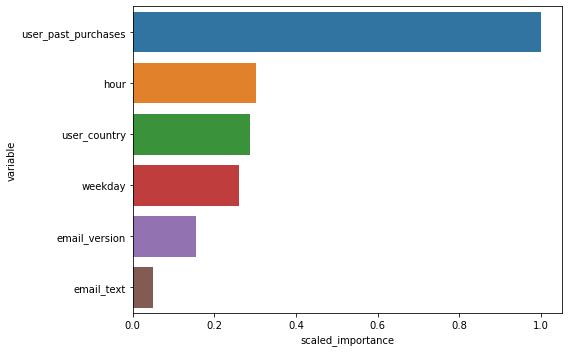

In [23]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [24]:
# Make predictions
train_true = train.as_data_frame()['clicked'].values
test_true = test.as_data_frame()['clicked'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000



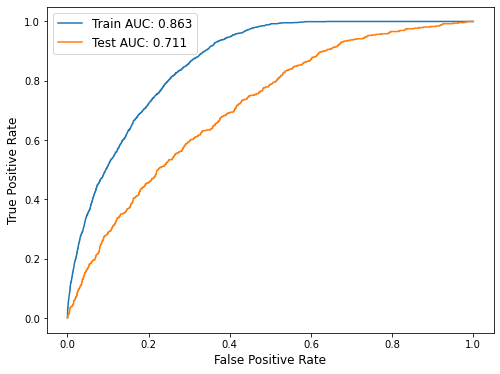

In [25]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


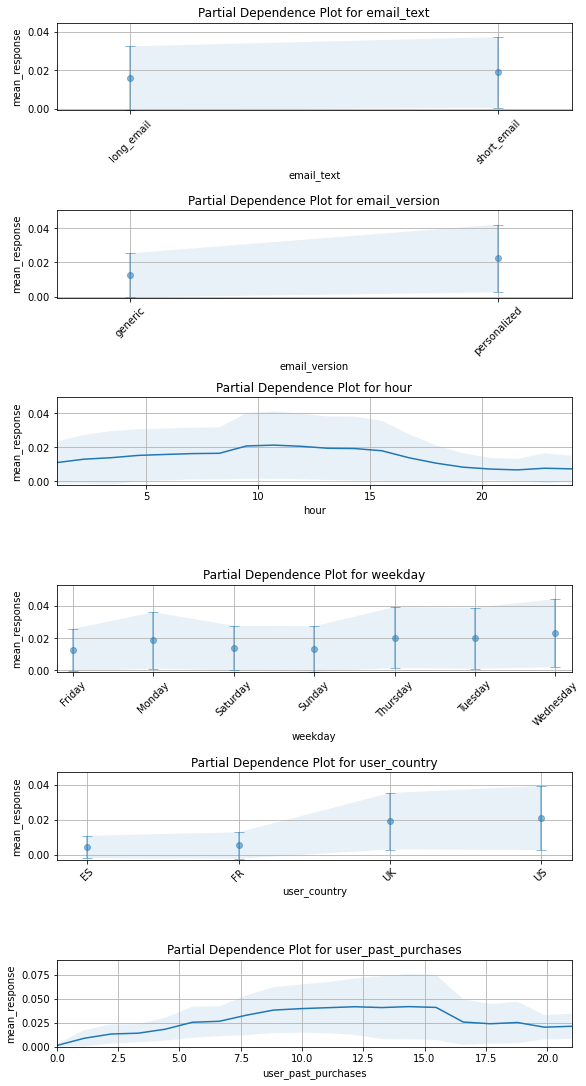

In [26]:
# Partial dependence plot
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

It seems that currently there are some overfitting, which could be solved with grid search.


## Question 3

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link.